In [150]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import math

import matplotlib.pyplot as plt

import imageio
import numpy as np
import torch.nn.functional as F

In [151]:
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = ImageFolder("data/dog_dataset/", transform=transform)
loader = DataLoader(dataset, batch_size=8, shuffle=True)



In [152]:
print("Dataset size:", len(dataset))
print("Classes:", dataset.classes)

x, y = dataset[0]
print("Image shape:", x.shape)
print("Label:", y)

Dataset size: 33
Classes: ['dog']
Image shape: torch.Size([3, 32, 32])
Label: 0


In [153]:
T = 1000

betas = torch.linspace(1e-4, 0.02, T)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

In [154]:
def q_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)

    sqrt_alpha_bar = alphas_cumprod[t] ** 0.5
    sqrt_one_minus = (1 - alphas_cumprod[t]) ** 0.5

    return sqrt_alpha_bar * x0 + sqrt_one_minus * noise

In [155]:
def show_samples(samples, epoch, n=4):
    """
    samples: (B, 3, H, W) in [-1, 1]
    """
    samples = (samples + 1) / 2
    samples = samples.clamp(0, 1)
    samples = samples.cpu()

    fig, axes = plt.subplots(1, n, figsize=(3*n, 3))
    for i in range(n):
        img = samples[i].permute(1, 2, 0)  # CHW -> HWC
        axes[i].imshow(img)
        axes[i].axis("off")

    plt.suptitle(f"Epoch {epoch}")
    plt.show()

In [156]:
import math

def sinusoidal_embedding(timesteps, dim):
    """
    timesteps: (B,) int64 or float
    returns: (B, dim)
    """
    device = timesteps.device
    half_dim = dim // 2

    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=device) * -emb)

    emb = timesteps[:, None].float() * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)

    return emb

class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, dim)
        )

    def forward(self, t):
        emb = sinusoidal_embedding(t, dim=self.net[0].in_features)
        return self.net(emb)

In [157]:
class TinyDenoiser(nn.Module):
    def __init__(self):
        super().__init__()

        self.time_embed = TimeEmbedding(32)

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 3, 3, padding=1)

    def forward(self, x, t):
        # t is (B,)
        t_emb = self.time_embed(t)          # (B, 32)
        t_emb = t_emb[:, :, None, None]     # (B, 32, 1, 1)

        h = self.conv1(x)
        h = h + t_emb
        h = F.relu(h)

        h = F.relu(self.conv2(h))
        return self.conv3(h)

In [158]:
device = "cuda" if torch.cuda.is_available() else "cpu"

@torch.no_grad()
def sample(model, shape=None, x_init=None, t_time=700):
    model.eval()

    if x_init is not None:
        x = x_init.clone()
    else:
        x = torch.randn(shape).to(device)

    for t in reversed(range(t_time)):
        pred_noise = model(x, torch.tensor([t], device=device))

        alpha = alphas[t]
        alpha_bar = alphas_cumprod[t]

        x = (1 / alpha**0.5) * (
            x - (1 - alpha) / (1 - alpha_bar)**0.5 * pred_noise
        )

        if t > 0:
            x += betas[t]**0.5 * torch.randn_like(x)

    return x

In [159]:
@torch.no_grad()
def generate_epoch_frame(model, fixed_latent):
    model.eval()

    x = sample(model, x_init=fixed_latent)

    # denormalize
    x = (x + 1) / 2
    x = x.clamp(0, 1)

    # upscale to 480p
    x = F.interpolate(
        x,
        size=(480, 480),
        mode="bilinear",
        align_corners=False
    )

    img = x[0].permute(1, 2, 0).cpu().numpy()
    img = (img * 255).astype(np.uint8)

    return img

epoch 0 loss 1.0243


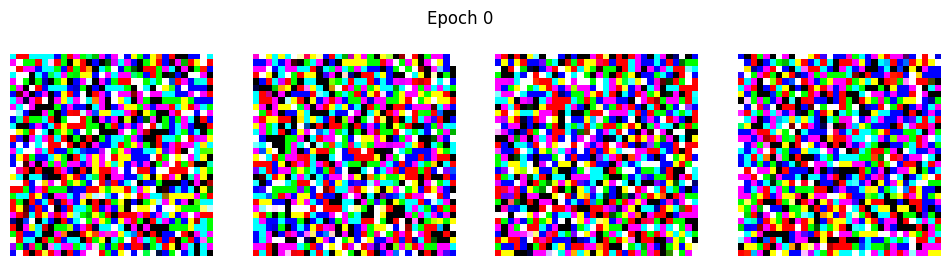

epoch 1 loss 0.9466
epoch 2 loss 0.8917
epoch 3 loss 0.8510
epoch 4 loss 0.7904
epoch 5 loss 0.9420


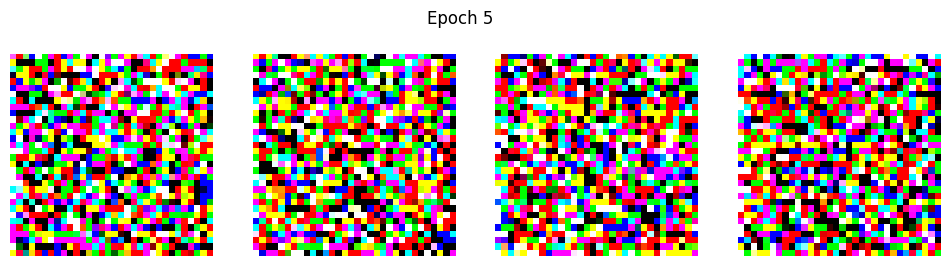

epoch 6 loss 0.7902
epoch 7 loss 0.6391
epoch 8 loss 0.8571
epoch 9 loss 0.5933
epoch 10 loss 0.4959


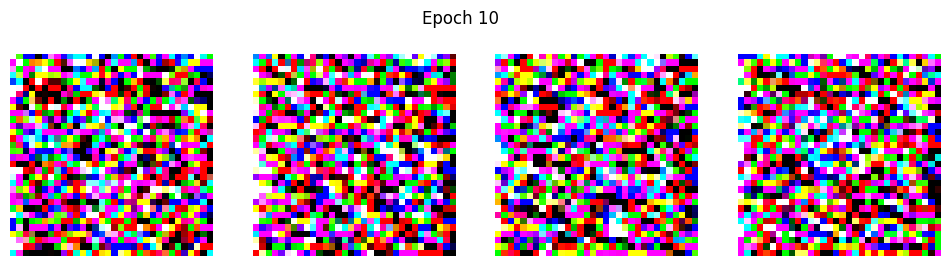

epoch 11 loss 0.7053
epoch 12 loss 0.9049
epoch 13 loss 0.2617
epoch 14 loss 0.2464
epoch 15 loss 0.6576


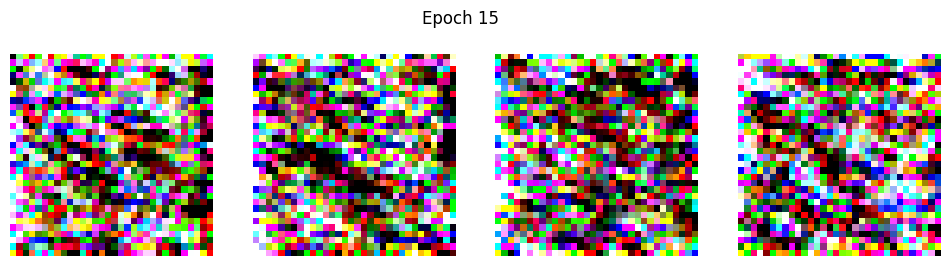

epoch 16 loss 0.1561
epoch 17 loss 1.0305
epoch 18 loss 0.1183
epoch 19 loss 0.1262
epoch 20 loss 0.0939


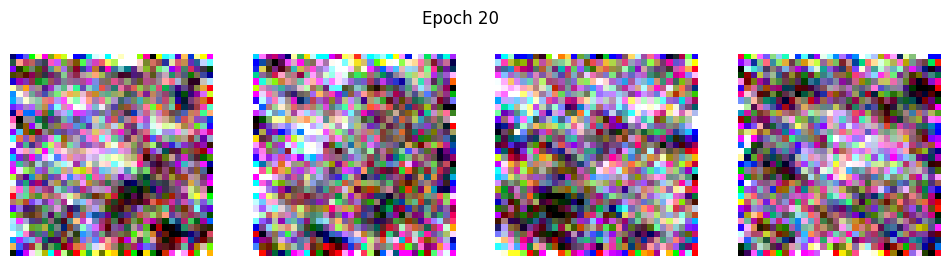

epoch 21 loss 0.0921
epoch 22 loss 0.0767
epoch 23 loss 0.0870
epoch 24 loss 0.0804
epoch 25 loss 0.5797


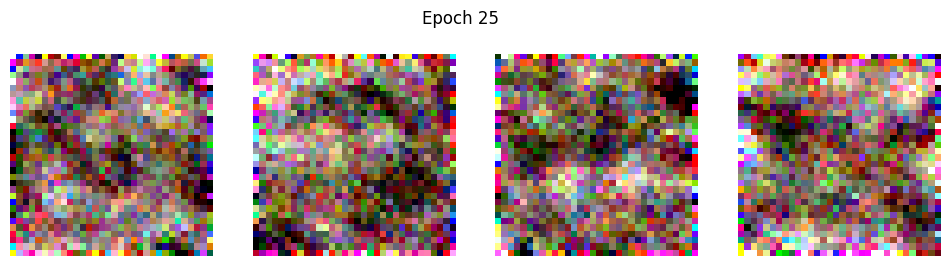

epoch 26 loss 0.0994
epoch 27 loss 0.0745
epoch 28 loss 0.4249
epoch 29 loss 0.0692
epoch 30 loss 0.3689


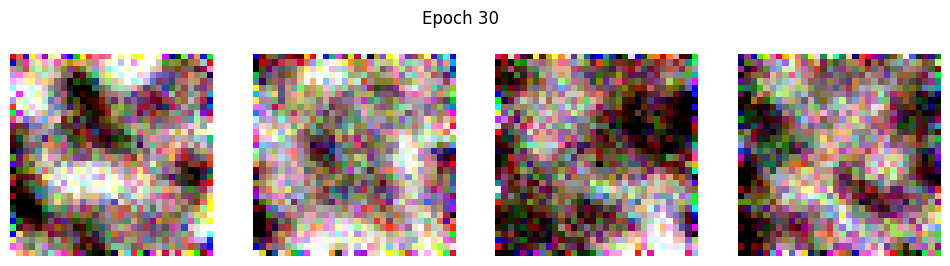

epoch 31 loss 0.0694
epoch 32 loss 0.0742
epoch 33 loss 0.0620
epoch 34 loss 0.0728
epoch 35 loss 0.3245


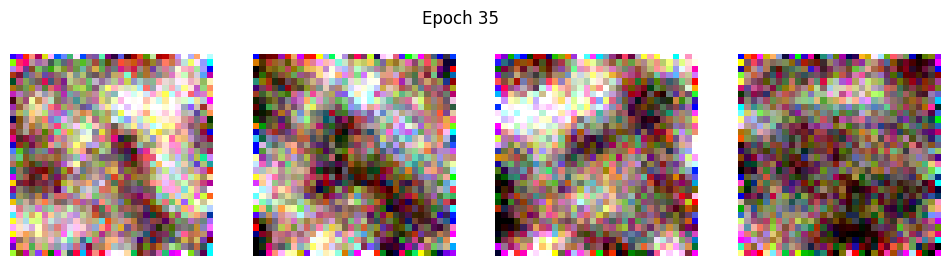

epoch 36 loss 0.0681
epoch 37 loss 0.0623
epoch 38 loss 0.9074
epoch 39 loss 0.5254
epoch 40 loss 0.0623


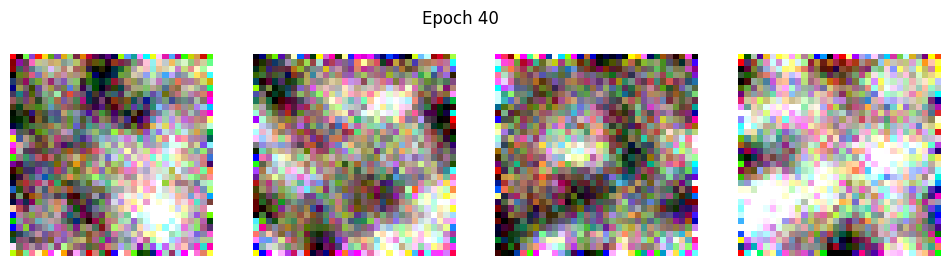

epoch 41 loss 0.0565
epoch 42 loss 0.0696
epoch 43 loss 0.0518
epoch 44 loss 0.0917
epoch 45 loss 0.9335


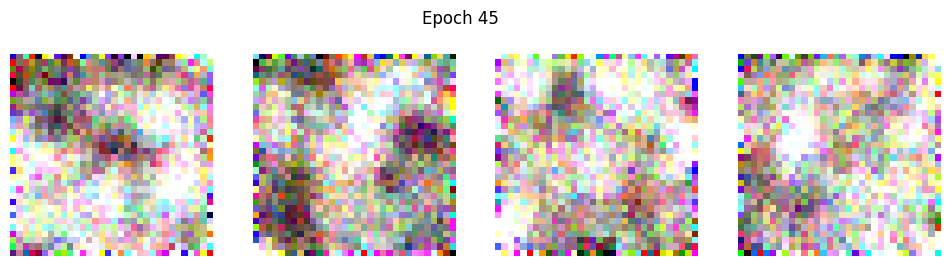

epoch 46 loss 0.0616
epoch 47 loss 0.0566
epoch 48 loss 0.0913
epoch 49 loss 0.0531


In [160]:
model = TinyDenoiser().to(device)
opt = torch.optim.Adam(model.parameters(), lr=3e-4)

fixed_latent = torch.randn(1, 3, 32, 32).to(device)

training_frames = []

for epoch in range(50):
    for x, _ in loader:
        x = x.to(device)

        t = torch.randint(0, T, (x.size(0),), device=device)
        noise = torch.randn_like(x)

        x_noisy = torch.stack([
            q_sample(x[i], t[i], noise[i])
            for i in range(x.size(0))
        ])

        pred_noise = model(x_noisy, t)
        loss = F.mse_loss(pred_noise, noise)

        opt.zero_grad()
        loss.backward()
        opt.step()

    print(f"epoch {epoch} loss {loss.item():.4f}")

    if epoch % 5 == 0:
        samples = sample(model, (4, 3, 32, 32))
        show_samples(samples, epoch)
        
    frame = generate_epoch_frame(model, fixed_latent)
    training_frames.append(frame)

In [161]:
for t_test in [50, 200, 500, 800]:
    frame = sample(model, x_init=fixed_latent, t_start=t_test)
    show_samples(frame.repeat(4,1,1,1), f"t_start={t_test}")

TypeError: sample() got an unexpected keyword argument 't_start'

In [162]:
imageio.mimsave(
    "training_progress.mp4",
    training_frames,
    fps=8
)

print("Saved training_progress.mp4")

Saved training_progress.mp4


In [ ]:
samples = sample(model, (4, 3, 32, 32))

In [ ]:
samples = (samples + 1) / 2
samples = samples.clamp(0, 1)

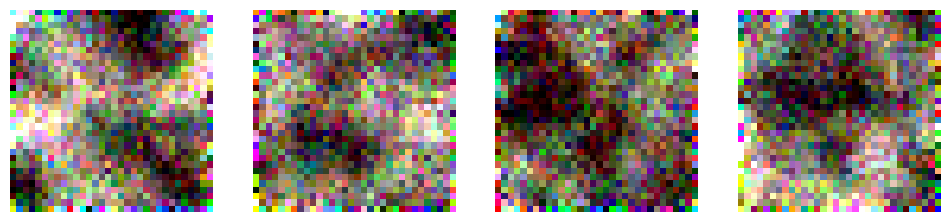

In [ ]:
grid = samples.cpu().permute(0, 2, 3, 1)

fig, axs = plt.subplots(1, grid.size(0), figsize=(12, 3))
for i, ax in enumerate(axs):
    ax.imshow(grid[i])
    ax.axis("off")

plt.show()

In [ ]:
from torchvision.utils import save_image

save_image(samples, "generated.png", nrow=4)